In [1]:
import sys
print(sys.version)

3.7.3 (default, Mar 27 2019, 09:23:15) 
[Clang 10.0.1 (clang-1001.0.46.3)]


In [556]:
import io
import pandas as pd
import numpy as np
import random
import re
import requests
from collections import namedtuple
from lxml import etree

# Read abstracts from PubMed API

In [4]:
PMID_XPATH = 'MedlineCitation/PMID/text()'
TITLE_XPATH = 'MedlineCitation/Article/ArticleTitle/text()'
ABSTRACT_XPATH = 'MedlineCitation/Article/Abstract/AbstractText/text()'

In [557]:
filename = '../data/pmids_gold_set_labeled.txt'
labeled_set = pd.read_csv(filename, sep='\t', names=['pmid', 'topic'])

In [558]:
Article = namedtuple('Article', 'pmid title abstract')

In [559]:
def join_text(nodes, delim='\n'):
    return delim.join(nodes) if nodes else ''

In [562]:
def fetch_abstracts(pubmed_ids):
    """
    Fetches abstracts from the Entrez API.

    Returns a dict mapping pubmed ids to abstracts.
    """
    url = ('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
          'efetch.fcgi'
          '?db=pubmed'
          '&retmode=xml'
          '&rettype=abstract'
          '&id={ids}').format(ids=','.join(str(pmid) for pmid in pubmed_ids))

    ## stream XML response into lxml parser
    response = requests.get(url, stream=True)
    root = etree.parse(io.BytesIO(response.content))

    ## extract abstracts for each article
    return [Article(
            pmid = join_text(article.xpath(PMID_XPATH)),
            title = join_text(article.xpath(TITLE_XPATH)),
            abstract = join_text(article.xpath(ABSTRACT_XPATH)),
        )
        for article in root.xpath('PubmedArticle')]

In [563]:
articles = fetch_abstracts(labeled_set.pmid)
print(len(articles))

103


# Look at most common words

In [564]:
import gensim
from gensim import corpora
from gensim import utils
from gensim.parsing.preprocessing import preprocess_documents, preprocess_string, remove_stopwords
from collections import Counter

Convert titles/abstracts into lists of individual words, filtering out stop words

In [565]:
texts = [
    (remove_stopwords(a.title.lower()).split() +
     remove_stopwords(a.abstract.lower()).split())
    for a in articles
]

In [566]:
df = Counter(w for t in texts for w in t)

In [567]:
len(df)

4196

How many words occur more than once in the corpus?

In [568]:
sum(n>1 for w,n in df.items())

1646

In [569]:
df.most_common(20)

[('cystic', 124),
 ('breast', 121),
 ('patients', 115),
 ('cancer', 85),
 ('fibrosis', 84),
 ('clinical', 80),
 ('treatment', 72),
 ('disease', 66),
 ('osteogenesis', 53),
 ('mutations', 51),
 ('genetic', 48),
 ('triple-negative', 47),
 ('expression', 38),
 ('tnbc', 38),
 ('bone', 38),
 ('bbs', 38),
 ('tumor', 37),
 ('type', 36),
 ('gene', 35),
 ('negative', 34)]

In [570]:
print(df['tnbc'],df['(tnbc)'],df['(tnbc),'])

38 12 1


In [571]:
[(w,n) for w,n in df.items() if '-' in w][:10]

[('triple-negative', 47),
 ('er-positive,', 1),
 ('her2-positive', 1),
 ('mir-26b,', 3),
 ('up-regulation', 1),
 ('up-regulated', 1),
 ('over-expression', 1),
 ('up-regulating', 1),
 ('gper-1.', 1),
 ('17β-oestradiol', 1)]

## Preprocess

In [572]:
medical_stopwords = {'patient', 'patients', 'clinical', 'treatment', 'disease',
                     'present', 'new', 'diagnosis', 'disorder', 'disorders', 'associated'}
STOPWORDS = gensim.parsing.preprocessing.STOPWORDS | medical_stopwords

In [573]:
def remove_stopwords(s):
    s = utils.to_unicode(s)
    return " ".join(w for w in s.split() if w not in STOPWORDS)

In [574]:
filters = [
    lambda x: x.lower(),
    gensim.parsing.preprocessing.strip_punctuation,
    gensim.parsing.preprocessing.strip_multiple_whitespaces,
    gensim.parsing.preprocessing.strip_numeric,
    remove_stopwords,
    #strip_short,
    gensim.parsing.preprocessing.stem_text
]

In [575]:
texts = [preprocess_string(a.title + ' ' + a.abstract, filters=filters) for a in articles]

In [576]:
df = Counter(w for t in texts for w in t)

In [577]:
len(df)

2197

In [578]:
sum(n>4 for w,n in df.items())

551

In [579]:
texts = [[w for w in t if df[w]>1] for t in texts]

In [580]:
dictionary = corpora.Dictionary(texts)

In [581]:
bows = [dictionary.doc2bow(text) for text in texts]

In [546]:
from gensim import models

In [547]:
tfidf = models.TfidfModel(dictionary=dictionary, normalize=True)

In [548]:
botfidfs = [tfidf[bow] for bow in bows]

In [549]:
def top_k(vec, dictionary, k=20):
    for k,v in sorted(vec, key=lambda x: -x[1])[:k]:
        print(f'{dictionary[k]:>20}   {v}')

In [550]:
top_k(botfidfs[0], dictionary)

               renal   0.37296096196096706
             syndrom   0.3390785425690986
            children   0.2384791824547612
              featur   0.22920249733257314
              bardet   0.19206791056397654
               biedl   0.19206791056397654
              involv   0.18020963145001753
                 end   0.17316531595231002
            concentr   0.1515510612071996
         polydactyli   0.1515510612071996
              aspect   0.14333370292829808
            diagnost   0.14333370292829808
           hypogonad   0.14333370292829808
               known   0.14333370292829808
                abil   0.13621550341139696
            consider   0.13621550341139696
             consist   0.13621550341139696
          particular   0.13621550341139696
              screen   0.13621550341139696
             similar   0.13621550341139696


In [553]:
articles[0]

Article(pmid='8270381', title='Clinical aspects of renal involvement in Bardet-Biedl syndrome.', abstract='The Bardet-Biedl syndrome (BBS), which consists of polydactyly, obesity, mental retardation, pigmentary retinopathy and hypogonadism has been known since 1922, but due to the great similarity to the clinical manifestations of the Laurence-Moon syndrome (LMS) there is a considerable terminological confusion in the medical literature. An attempt is made at clarifying the problem. Four children from two families have been observed. There were inter- and intrafamilial variabilities of the expression and severity of the particular features, but retinopathy and structural and/or functional abnormalities were found in 100%. The combination of the two can serve as an easy clinical screening for diagnosis of the disease. Renal involvement is considered to be a cardinal feature of the syndrome. The most common and earliest symptoms are polydypso-polyuria and reduced concentrating ability, w

In [554]:
top_k(botfidfs[1], dictionary)

         intradialyt   0.6820470986698516
            hypotens   0.5683725822248764
              recurr   0.2091858139889342
               renal   0.1715992436090235
               activ   0.16458631666396037
             respons   0.10545601064726189
              report   0.09451006953274313
                 end   0.079673317766281
        characterist   0.07420034720902163
              reduct   0.07420034720902163
               volum   0.07420034720902163
            efficaci   0.06972860466297807
       significantli   0.06972860466297807
             consequ   0.06594780021172984
               induc   0.06594780021172984
             consist   0.06267271842693387
           intervent   0.06267271842693387
             complic   0.05978389155967514
               stage   0.057199747869674494
             decreas   0.057199747869674494


In [555]:
articles[1]

Article(pmid='8712208', title='Midodrine efficacy and pharmacokinetics in a patient with recurrent intradialytic hypotension.', abstract='Recurrent intradialytic hypotension, a complication of hemodialysis, is a consequence of an inadequate compensatory response or a paradoxic response to ultrafiltration-induced volume reduction. We report the use of midodrine, an alpha agonist, in an 18-year-old man with Bardet-Biedl syndrome and recurrent intradialytic hypotension. The clinical features of the intradialytic hypotensive spells are consistent with a paradoxic withdrawal of sympathetic activity, although an underlying abnormality in autonomic dysfunction cannot be excluded. Midodrine significantly increased the intradialytic blood pressure and decreased the intradialytic hypotensive episodes requiring intervention. The pharmacokinetic characteristics of the prodrug midodrine and the active metabolite de-glymidodrine in this patient with end-stage renal disease approximate those reported

In [552]:
from gensim.models import Phrases

In [504]:
bigrams = Phrases(texts, min_count=2)

In [505]:
bigrams[texts[0]]

['aspect',
 'renal',
 'involv',
 'bardet_biedl',
 'syndrom',
 'bardet_biedl',
 'syndrom_bb',
 'consist',
 'polydactyli_obes',
 'retinopathi',
 'hypogonad',
 'known',
 'great',
 'similar',
 'manifest',
 'laurenc_moon',
 'syndrom',
 'consider',
 'medic',
 'literatur',
 'attempt',
 'clarifi',
 'problem',
 'children',
 'famili',
 'observ',
 'variabl_express',
 'sever',
 'particular',
 'featur',
 'retinopathi',
 'structur_function',
 'abnorm',
 'combin',
 'easi',
 'screen',
 'renal',
 'involv',
 'consid',
 'cardin',
 'featur',
 'syndrom',
 'common',
 'earliest',
 'symptom',
 'reduc',
 'concentr',
 'abil',
 'lead',
 'diagnost',
 'difficulti',
 'especi',
 'infanc',
 'children',
 'end_stage',
 'renal',
 'mainten',
 'toler']

## LDA

In [582]:
from gensim.models.ldamodel import LdaModel

In [583]:
%%time
n_topics = 6
lda = LdaModel(bows, id2word=dictionary, num_topics=n_topics,
               alpha='auto', eta='auto',
               iterations=1000, passes=100)

CPU times: user 10.8 s, sys: 32.5 ms, total: 10.8 s
Wall time: 10.9 s


These topics are very confused. It combines bardet-biedl syndrome with neurofibromatosis and splits breast cancer among 3 different topics.

In [584]:
lda.show_topics()

[(0,
  '0.050*"bb" + 0.021*"syndrom" + 0.018*"biedl" + 0.018*"bardet" + 0.015*"mutat" + 0.013*"cilia" + 0.010*"renal" + 0.010*"genet" + 0.010*"dysfunct" + 0.009*"protein"'),
 (1,
  '0.050*"fibrosi" + 0.049*"cystic" + 0.022*"cf" + 0.016*"gene" + 0.013*"therapi" + 0.012*"lung" + 0.011*"cftr" + 0.010*"smn" + 0.009*"mir" + 0.009*"regul"'),
 (2,
  '0.027*"imperfecta" + 0.027*"osteogenesi" + 0.023*"bone" + 0.019*"type" + 0.018*"oi" + 0.012*"therapi" + 0.012*"collagen" + 0.011*"fractur" + 0.010*"mutat" + 0.010*"gene"'),
 (3,
  '0.045*"cancer" + 0.039*"breast" + 0.027*"cell" + 0.026*"neg" + 0.023*"tripl" + 0.022*"tnbc" + 0.018*"tumor" + 0.017*"express" + 0.015*"ar" + 0.013*"respons"'),
 (4,
  '0.017*"cystic" + 0.017*"fibrosi" + 0.015*"genet" + 0.009*"motor" + 0.009*"function" + 0.007*"includ" + 0.007*"sma" + 0.007*"ifitm" + 0.007*"interact" + 0.006*"review"'),
 (5,
  '0.029*"breast" + 0.028*"cancer" + 0.024*"neg" + 0.023*"tripl" + 0.022*"tnbc" + 0.019*"neurofibromatosi" + 0.015*"tumor" + 0.009

In [585]:
lda.get_document_topics(bows[0])

[(2, 0.20266332), (5, 0.7960896)]

In [586]:
dtm = np.array([
    [dict(lda.get_document_topics(v)).get(topic, 0.0) for topic in range(n_topics)]
    for v in bows
])

In [587]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

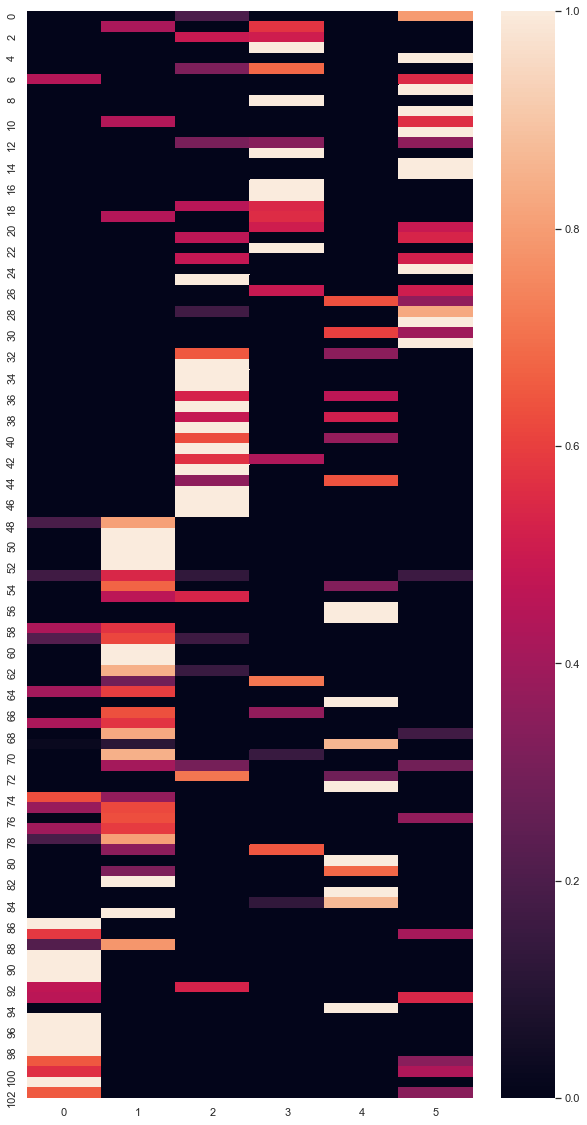

In [588]:
fig, ax = plt.subplots(figsize=(10,20))
ax = sns.heatmap(dtm, vmin=0, vmax=1, ax=ax)

### Are these documents too short for LDA?

Text(0, 0.5, 'documents')

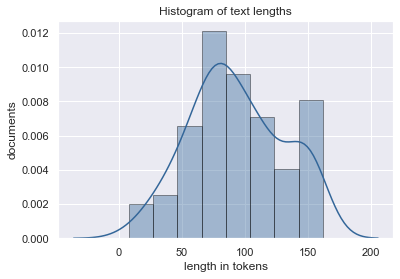

In [589]:
sns.distplot([len(t) for t in texts], hist=True,
             color = '#336699',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of text lengths')
plt.xlabel('length in tokens')
plt.ylabel('documents')

## Coherence measure

In [594]:
from gensim.models.coherencemodel import CoherenceModel

In [595]:
coherence_model_lda = CoherenceModel(model=lda,
                                     texts=texts,
                                     dictionary=dictionary,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.46379556592156085
